In [5]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score,
precision_recall_curve, classification_report,
confusion_matrix)
import joblib

In [7]:
df = pd.read_csv("Credit/creditcard.csv")

In [9]:

print("Rows, Columns:", df.shape)
df.head()

Rows, Columns: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
print("Class distribution:\n", df['Class'].value_counts())
print("Fraud percentage: {:.4f}%".format(df['Class'].mean() * 100))

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Fraud percentage: 0.1727%


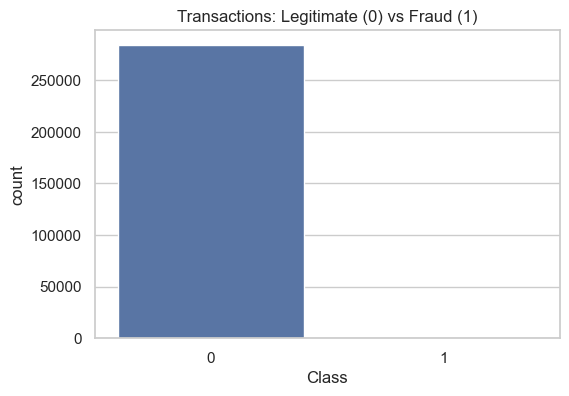

In [11]:

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Transactions: Legitimate (0) vs Fraud (1)')
plt.show()

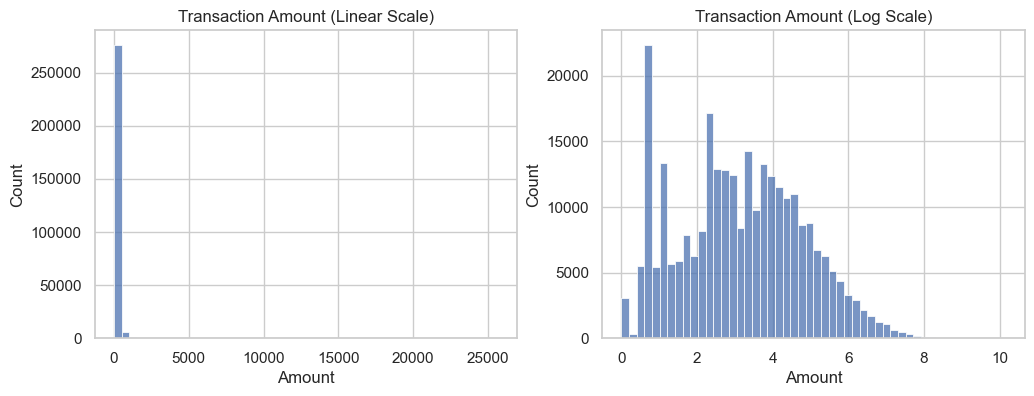

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Amount'], bins=50)
plt.title('Transaction Amount (Linear Scale)')
plt.subplot(1,2,2)
sns.histplot(np.log1p(df['Amount']), bins=50)
plt.title('Transaction Amount (Log Scale)')
plt.show()

In [13]:
# 3. Preprocessing

X = df.drop(columns=['Class'])
y = df['Class']
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['Time','Amount']] = scaler.fit_transform(X[['Time','Amount']])

In [14]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, stratify=y, random_state=42)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (227845, 30) Test size: (56962, 30)


In [27]:
# 5. Logistic Regression Model

lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', random_state=42)
lr.fit(X_train, y_train)
y_probs_lr = lr.predict_proba(X_test)[:,1]
print("Logistic Regression - ROC AUC:", roc_auc_score(y_test, y_probs_lr))
print("Logistic Regression - AP:", average_precision_score(y_test, y_probs_lr))

Logistic Regression - ROC AUC: 0.972000595046685
Logistic Regression - AP: 0.719451816225037


C:\Users\Nick_Oza\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# 6. Random Forest Model

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_probs_rf = rf.predict_proba(X_test)[:,1]
print("Random Forest - ROC AUC:", roc_auc_score(y_test, y_probs_rf))
print("Random Forest - AP:", average_precision_score(y_test, y_probs_rf))

In [25]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_probs_rf = rf.predict_proba(X_test)[:, 1]


In [22]:
try:
    y_probs_rf
except NameError:
    print("Random Forest probabilities not found — run the RF training cell first!")


Random Forest probabilities not found — run the RF training cell first!


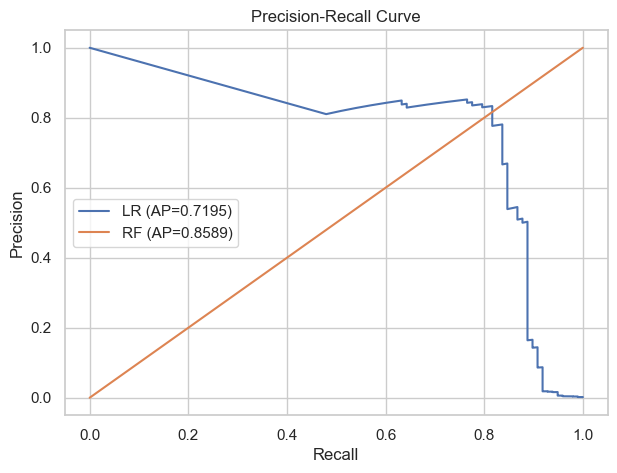

In [26]:
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_probs_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_probs_rf)


plt.figure(figsize=(7,5))
plt.plot(rec_lr, prec_lr, label=f'LR (AP={average_precision_score(y_test,y_probs_lr):.4f})')
plt.plot(rec_rf, rec_rf, label=f'RF (AP={average_precision_score(y_test,y_probs_rf):.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [28]:
# 8. Choose Threshold (80% Recall Example)

precision, recall, thresholds = precision_recall_curve(y_test, y_probs_rf)
target_recall = 0.80
idx = np.where(recall >= target_recall)[0]
chosen_threshold = thresholds[idx[-1]] if len(idx) > 0 else 0.5
print('Chosen threshold for recall >= 80%:', chosen_threshold)


y_pred_adj = (y_probs_rf >= chosen_threshold).astype(int)
print(classification_report(y_test, y_pred_adj, digits=4))

Chosen threshold for recall >= 80%: 0.39
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9518    0.8061    0.8729        98

    accuracy                         0.9996     56962
   macro avg     0.9757    0.9030    0.9364     56962
weighted avg     0.9996    0.9996    0.9996     56962



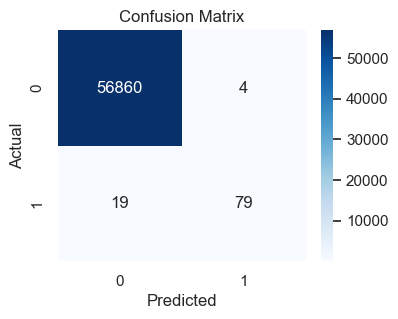

In [29]:
# 9. Confusion Matrix & Cost Analysis

cm = confusion_matrix(y_test, y_pred_adj)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [30]:
tn, fp, fn, tp = cm.ravel()
cost_miss = 100 # cost of missed fraud
cost_fp = 10 # cost of investigating false alarm
total_cost = fn*cost_miss + fp*cost_fp
print(f'Total cost (example): {total_cost} | FN={fn}, FP={fp}')

Total cost (example): 1940 | FN=19, FP=4


In [31]:
# 10. Save Model & Scaler

os.makedirs('models', exist_ok=True)
joblib.dump(rf, 'models/fraud_rf_simple.joblib')
joblib.dump(scaler, 'models/amount_time_scaler.joblib')
print('Saved Random Forest model and scaler to ./models/')

Saved Random Forest model and scaler to ./models/
